In [13]:
# Imports, as always...
import os
import re
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn as nn
from torch.utils.data import DataLoader

from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss

from tqdm.notebook import tqdm

from data_handling import ISICDataset

from datetime import datetime

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Spectral')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.set_default_device('cuda')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

print(f'Date: {date_string}')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121
Date: 2024-03-14-(21-20-24)


## Data Handling

In [10]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

## Segmentation, and Whatnot

In [2]:
# Demonstrate model's segmentation.
def side_by_side_model_segmentation(model, example_sample, cmap='bone'):
    # Break apart the sample and move to device.
    example_input, example_target = example_sample
    example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
    example_target = example_target.to('cuda')
    example_output, _ = model(example_input, example_target)
    
    # Show them.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
    ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
    ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
    ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)
    
    # Memory saving.
    del example_sample
    del example_input
    del example_target
    del example_output
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    ax1.set_title('Corrupted Input')
    ax2.set_title('Predicted Mask')
    ax3.set_title('True Mask')

In [11]:
# Define the model.
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.model = UnetPlusPlus(
            encoder_name='timm-efficientnet-b0',
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )
    
    def forward(self, x, y_true):
        y_pred = self.model(x)
        
        if y_true is not None:
            loss = DiceLoss(mode='binary')(y_pred, y_true)
            return y_pred, loss
        
        return y_pred
    
model = SegmentationModel()
model = model.to('cuda')

Training:   0%|          | 0/20 [00:00<?, ?it/s]

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 000: train loss - 0.4706 | val loss - 0.3062
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 001: train loss - 0.2895 | val loss - 0.2274
Model saved.


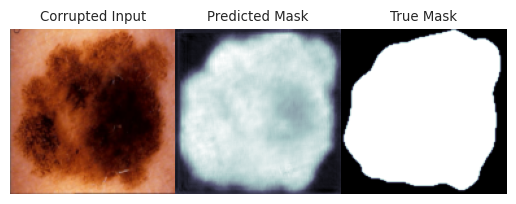

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 002: train loss - 0.1952 | val loss - 0.1880
Model saved.


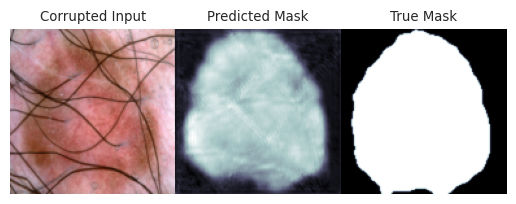

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 003: train loss - 0.1408 | val loss - 0.1435
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 004: train loss - 0.1167 | val loss - 0.1322
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 005: train loss - 0.1007 | val loss - 0.1142
Model saved.


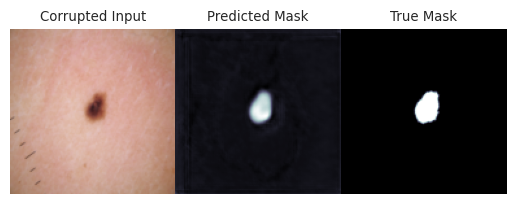

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 006: train loss - 0.0881 | val loss - 0.1206


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 007: train loss - 0.0819 | val loss - 0.1183


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 008: train loss - 0.0761 | val loss - 0.1370


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 009: train loss - 0.0709 | val loss - 0.1171


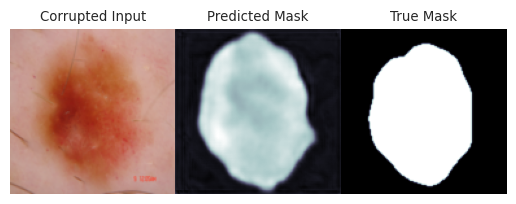

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 010: train loss - 0.0700 | val loss - 0.1247


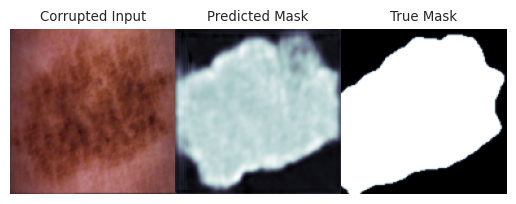

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 011: train loss - 0.0694 | val loss - 0.1197


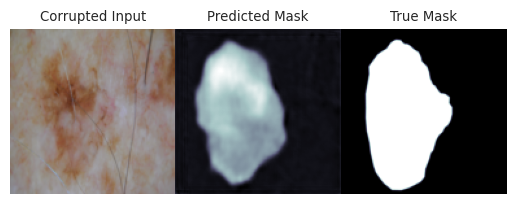

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 012: train loss - 0.0654 | val loss - 0.1195


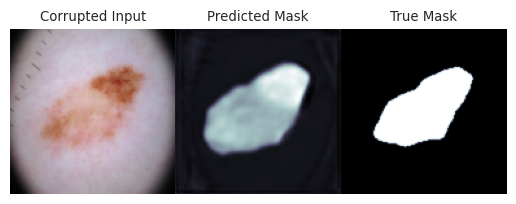

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 013: train loss - 0.0602 | val loss - 0.1116
Model saved.


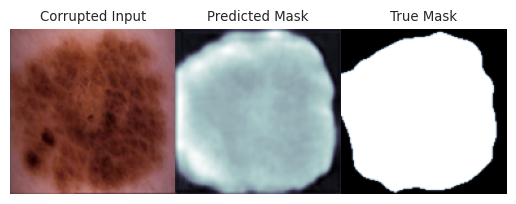

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 014: train loss - 0.0561 | val loss - 0.1292


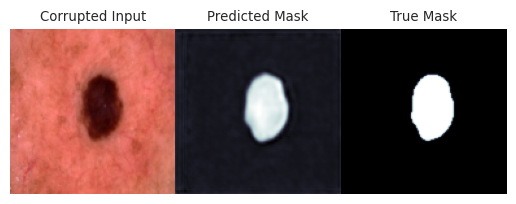

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 015: train loss - 0.0535 | val loss - 0.1229


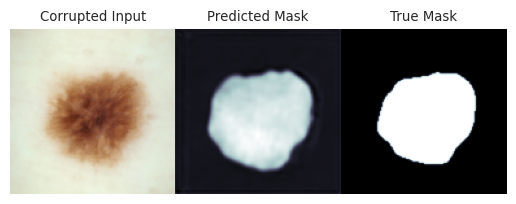

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 016: train loss - 0.0535 | val loss - 0.1064
Model saved.


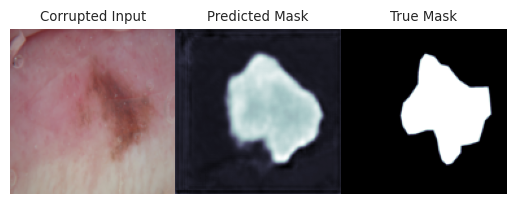

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 017: train loss - 0.0500 | val loss - 0.1268


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 018: train loss - 0.0482 | val loss - 0.1264


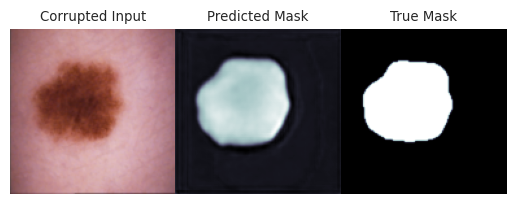

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 019: train loss - 0.0459 | val loss - 0.1232


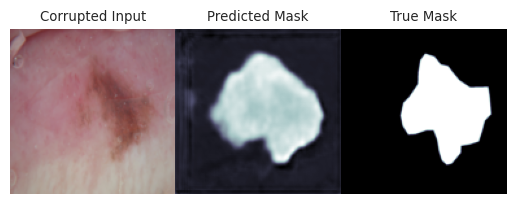

In [12]:
# Train one epoch.
def train(model, train_loader, optimiser):
    model.train()
    train_loss = .0
    
    for inputs, targets in tqdm(train_loader, desc='In-epoch training'):
        # Move to device.
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        
        optimiser.zero_grad()
        y_pred, loss = model(inputs, targets)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)

# Test the model.
def test(model, val_loader):
    model.eval()
    val_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='In-epoch validation'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            _, loss = model(inputs, targets)
            val_loss += loss.item()
            
        return val_loss / len(val_loader)
    
# Optimiser and scheduler.
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)

best_val_loss = np.inf
n_epochs = 20
os.makedirs(f'./models/unet/saves/{date_string}', exist_ok=True) 
for epoch_idx in tqdm(range(n_epochs), desc='Training'):
    train_loss = train(model, train_dataloader, optimiser)
    val_loss = test(model, val_dataloader)
    
    print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.4f} | val loss - {val_loss:.4f}')
    
    # Write stats to file.
    with open(f'./models/unet/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Save the model if it's the best yet.
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./models/unet/saves/{date_string}/model-state-dict.pt')
        best_val_loss = val_loss
        print('Model saved.')
        
    # Let's have a little looksie.
    side_by_side_model_segmentation(model, val_dataset[np.random.randint(0, len(val_dataset)-1)])
    plt.show()

## Segmentation on Damaged Data

In [3]:
from models.image_segmentation import SegmentationModel

In [7]:
model = SegmentationModel()
model = model.to('cuda')

# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

Training:   0%|          | 0/20 [00:00<?, ?it/s]

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 000: train loss - 0.4711 | val loss - 0.2898
Model saved.


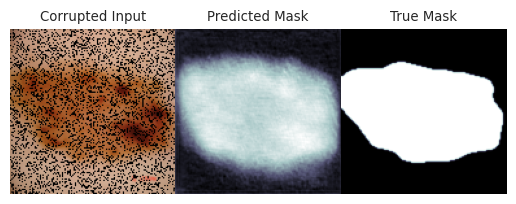

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 001: train loss - 0.2738 | val loss - 0.2058
Model saved.


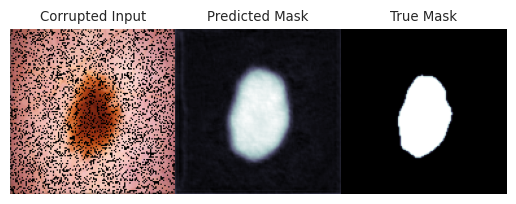

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 002: train loss - 0.2111 | val loss - 0.1797
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 003: train loss - 0.1702 | val loss - 0.1450
Model saved.


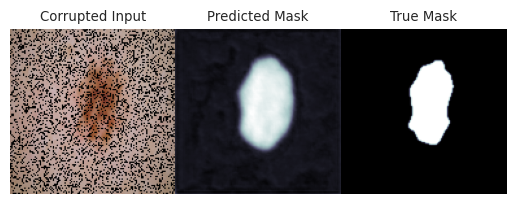

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 004: train loss - 0.1481 | val loss - 0.1417
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 005: train loss - 0.1374 | val loss - 0.1268
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 006: train loss - 0.1264 | val loss - 0.1424


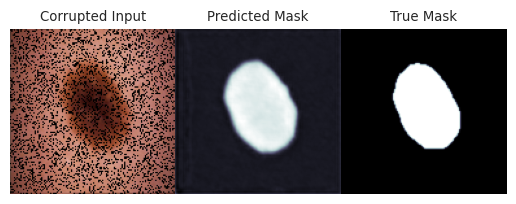

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 007: train loss - 0.1169 | val loss - 0.1241
Model saved.


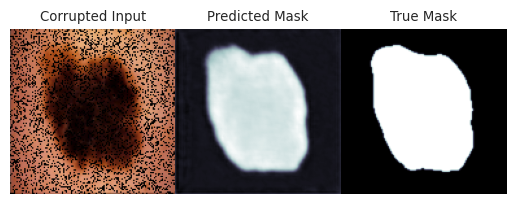

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 008: train loss - 0.1107 | val loss - 0.1269


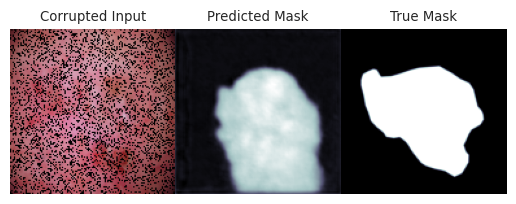

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 009: train loss - 0.1052 | val loss - 0.1117
Model saved.


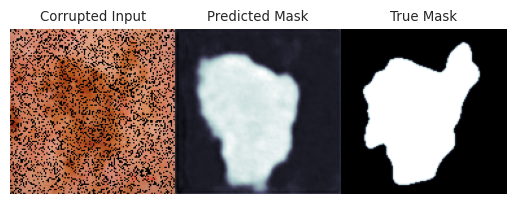

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 010: train loss - 0.1056 | val loss - 0.1195


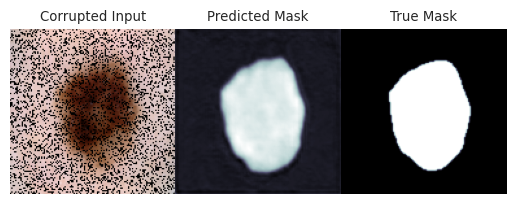

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 011: train loss - 0.1046 | val loss - 0.1142


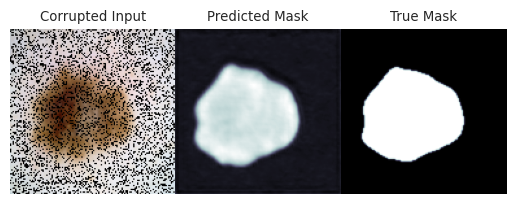

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 012: train loss - 0.0993 | val loss - 0.1314


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 013: train loss - 0.0918 | val loss - 0.1105
Model saved.


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 014: train loss - 0.0878 | val loss - 0.1161


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 015: train loss - 0.0859 | val loss - 0.1220


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 016: train loss - 0.0835 | val loss - 0.1127


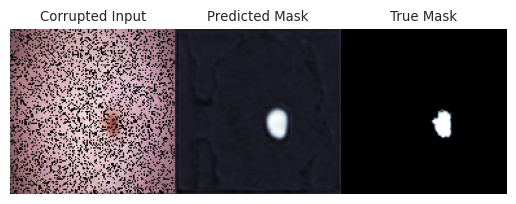

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 017: train loss - 0.0783 | val loss - 0.1436


In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 018: train loss - 0.0795 | val loss - 0.1135


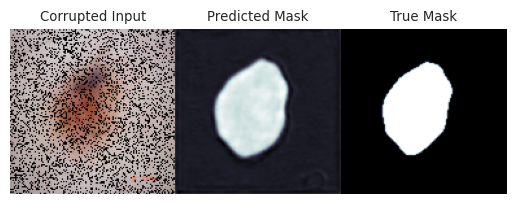

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 019: train loss - 0.0772 | val loss - 0.1281


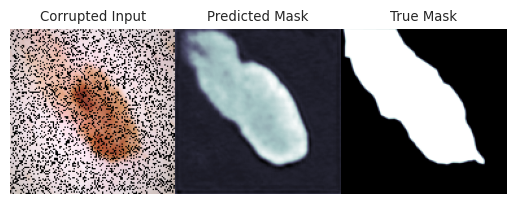

In [8]:
# Train one epoch.
def train(model, train_loader, optimiser):
    model.train()
    train_loss = .0
    
    for inputs, targets in tqdm(train_loader, desc='In-epoch training'):
        # Move to device.
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        
        optimiser.zero_grad()
        y_pred, loss = model(inputs, targets)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)

# Test the model.
def test(model, val_loader):
    model.eval()
    val_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='In-epoch validation'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            _, loss = model(inputs, targets)
            val_loss += loss.item()
            
        return val_loss / len(val_loader)
    
# Optimiser and scheduler.
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)

best_val_loss = np.inf
n_epochs = 20
os.makedirs(f'./models/unet/saves/{date_string}', exist_ok=True) 
for epoch_idx in tqdm(range(n_epochs), desc='Training'):
    train_loss = train(model, train_dataloader, optimiser)
    val_loss = test(model, val_dataloader)
    
    print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.4f} | val loss - {val_loss:.4f}')
    
    # Write stats to file.
    with open(f'./models/unet/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Save the model if it's the best yet.
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./models/unet/saves/{date_string}/model-state-dict.pt')
        best_val_loss = val_loss
        print('Model saved.')
        
    # Let's have a little looksie.
    side_by_side_model_segmentation(model, val_dataset[np.random.randint(0, len(val_dataset)-1)])
    plt.show()

## Comparing the Models

In [24]:
# Fully-trained U-Net for clean data: 2024-03-14-(17-17-31)
clean_model_stats = pd.read_csv('./models/unet/saves/2024-03-14-(17-17-31)/stats.csv', header=None).rename(columns={0 : 'Epoch', 1 : 'Train loss', 2 : 'Val loss'})
clean_model_stats['Epoch'] = clean_model_stats['Epoch'] + 1

# Fully-trained U-Net for 25% uniformly randomly corrupted data: 2024-03-14-(12-48-12)
damaged_model_stats = pd.read_csv('./models/unet/saves/2024-03-14-(12-48-12)/stats.csv', header=None).rename(columns={0 : 'Epoch', 1 : 'Train loss', 2 : 'Val loss'})
damaged_model_stats['Epoch'] = damaged_model_stats['Epoch'] + 1

Text(0.5, 1.0, 'Clean vs. Damaged U-Net Segmentation')

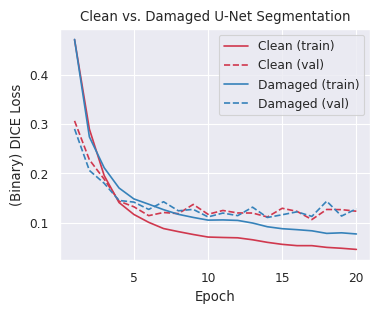

In [26]:
# Plot those losses, eh
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

colours = sns.color_palette('Spectral', n_colors=10)

sns.lineplot(data=clean_model_stats, x='Epoch', y='Train loss', linestyle='-', color=colours[0], ax=ax, label='Clean (train)')
sns.lineplot(data=clean_model_stats, x='Epoch', y='Val loss', linestyle='--', color=colours[0], ax=ax, label='Clean (val)')
sns.lineplot(data=damaged_model_stats, x='Epoch', y='Train loss', linestyle='-', color=colours[-1], ax=ax, label='Damaged (train)')
sns.lineplot(data=damaged_model_stats, x='Epoch', y='Val loss', linestyle='--', color=colours[-1], ax=ax, label='Damaged (val)')

ax.set_ylabel('(Binary) DICE Loss')
ax.set_title('Clean vs. Damaged U-Net Segmentation')

### How much performance does the clean model lose when tested on damaged data?

In [27]:
# Fully-trained U-Net for clean data: 2024-03-14-(17-17-31)
clean_model = SegmentationModel()
clean_model.load_state_dict(torch.load('./models/unet/saves/2024-03-14-(17-17-31)/model-state-dict.pt'))

<All keys matched successfully>

In [35]:
# Evaluating a given model on a given dataloader.
def test(model, test_loader):
    model.eval()
    test_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='In-epoch validation'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            _, loss = model(inputs, targets)
            test_loss += loss.item()
            
            # Memory saving.
            del inputs
            del targets
            del loss
            
        return test_loss / len(test_loader)

In [43]:
# Performance on different degrees of damage.
damage_degrees = [0, .10, .25, .50, .95]

performance_dict = {}
for damage_degree in tqdm(damage_degrees):
    # Train.
    train_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Training_Input',
        target_path='ISIC2018_Task1_Training_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    train_performance = test(clean_model, train_dataloader)
    
    del train_dataset
    del train_dataloader
    
    # Validation.
    val_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Validation_Input',
        target_path='ISIC2018_Task1_Validation_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    val_performance = test(clean_model, val_dataloader)
    
    del val_dataset
    del val_dataloader
    
    # Test.
    test_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Test_Input',
        target_path='ISIC2018_Task1_Test_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    test_performance = test(clean_model, test_dataloader)
    
    del test_dataset
    del test_dataloader
    
    # Write stats to file.
    with open(f'./models/unet/saves/2024-03-14-(17-17-31)/damage-performance.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([damage_degree, train_performance, val_performance, test_performance])

    print(f'Damage degree - {damage_degree}: train - {train_performance}, val - {val_performance}, test - {test_performance}')

  0%|          | 0/5 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/63 [00:00<?, ?it/s]

Damage degree - 0: train - 0.05371238117569063, val - 0.11398780345916748, test - 0.12899337117634121


In-epoch validation:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/63 [00:00<?, ?it/s]

Damage degree - 0.1: train - 0.23299464528546013, val - 0.19149566548211233, test - 0.23940046912147886


In-epoch validation:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/63 [00:00<?, ?it/s]

Damage degree - 0.25: train - 0.7370515480363296, val - 0.6061918990952628, test - 0.5935344894727071


In-epoch validation:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/63 [00:00<?, ?it/s]

Damage degree - 0.5: train - 0.9027540581357991, val - 0.862839230469295, test - 0.8365147350326417


In-epoch validation:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/63 [00:00<?, ?it/s]

Damage degree - 0.95: train - 0.6249841619854325, val - 0.586296158177512, test - 0.6088423624871269


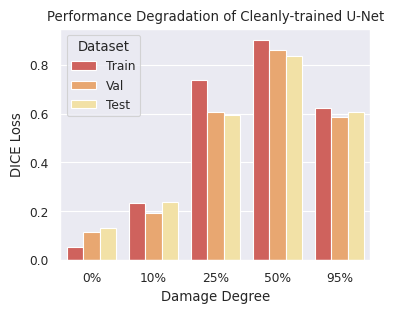

In [69]:
# Bar plot that shit.
clean_performance_data = pd.read_csv('./models/unet/saves/2024-03-14-(17-17-31)/damage-performance.csv', header=None).rename(columns={0 : 'Damage Degree', 1 : 'Train', 2 : 'Val', 3 : 'Test'})
clean_performance_data['Damage Degree'] = clean_performance_data['Damage Degree'].apply(lambda x : f'{int(100 * x)}%')

# Melt the dataframe into long format.
# Ignore the 95% damage case -- the model is clearly statically guessing.
clean_performance_melted = pd.melt(clean_performance_data, id_vars='Damage Degree', var_name='Dataset', value_name='DICE Loss')
clean_performance_melted

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=clean_performance_melted, x='Damage Degree', y='DICE Loss', hue='Dataset', ax=ax)

ax.set_title('Performance Degradation of Cleanly-trained U-Net')

plt.savefig('./misc-figures/clean-unet-performance-degradation-with-damage.pdf', bbox_inches='tight')